<a href="https://colab.research.google.com/github/badek23/forest-fire-detection/blob/main/fire-detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model Training

In [2]:
# Check that we are on GPU
!nvidia-smi

Wed Jul  3 18:56:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   53C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
# Create Home variable
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
# Pip install YOLOv10
!pip install -q git+https://github.com/THU-MIG/yolov10.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 47.1 MB/s eta 0:00:00


In [10]:
# Pip install supervision and roboflow
!pip install -q supervision roboflow

In [6]:
# Download weights
!mkdir -p {HOME}/weights
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10n.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10s.pt
!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10m.pt
#!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10b.pt
#!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10x.pt
#!wget -P {HOME}/weights -q https://github.com/THU-MIG/yolov10/releases/download/v1.1/yolov10l.pt
!ls -lh {HOME}/weights

total 107M
-rw-r--r-- 1 root root 64M May 26 15:54 yolov10m.pt
-rw-r--r-- 1 root root 11M May 26 15:54 yolov10n.pt
-rw-r--r-- 1 root root 32M May 26 15:54 yolov10s.pt


In [7]:
# Import YOLOv10 from ultralytics
from ultralytics import YOLOv10

In [11]:
# Create and navigate to datasets directory
!mkdir {HOME}/datasets
%cd {HOME}/datasets

!pip install -q roboflow

mkdir: cannot create directory ‘/content/datasets’: File exists
/content/datasets


In [28]:
# Import libraries
from google.colab import userdata
from roboflow import Roboflow

# Create connection to Roboflow workspace
rf = Roboflow(api_key="ULUfcs475oo0dWNDRqDv")

#project = rf.workspace("vishal-sharma-hfh1k").project("fire-smoke-detection-1oemc")
#version = project.version(3)

#project = rf.workspace("ly-project").project("forest-fire-detection-ilo2d")
#version = project.version(1)

project = rf.workspace("mccaai-ohxca").project("fire-u163g")
version = project.version(2)


dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.1.34, to fix: `pip install ultralytics==8.0.196`


In [29]:
 # Put data into correct format for training
 !sed -i '$d' {dataset.location}/data.yaml
 !sed -i '$d' {dataset.location}/data.yaml
 !sed -i '$d' {dataset.location}/data.yaml
 !sed -i '$d' {dataset.location}/data.yaml
 !echo -e "test: ../test/images\ntrain: ../train/images\nval: ../valid/images" >> {dataset.location}/data.yaml

In [30]:
# Train model

# I decided to upgrade to the YOLOv10s (small) version of YOLOv10. Additionally, I decreased batch size to 16 and increased epochs to 100.
%cd {HOME}

!yolo task=detect mode=train epochs=100 batch=16 lr0=0.01 plots=True \
model=/content/weights/yolov10s.pt \
data={dataset.location}/data.yaml

/content
New https://pypi.org/project/ultralytics/8.2.48 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.34 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=/content/weights/yolov10s.pt, data=/content/fire-2/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, val_period=1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

/content


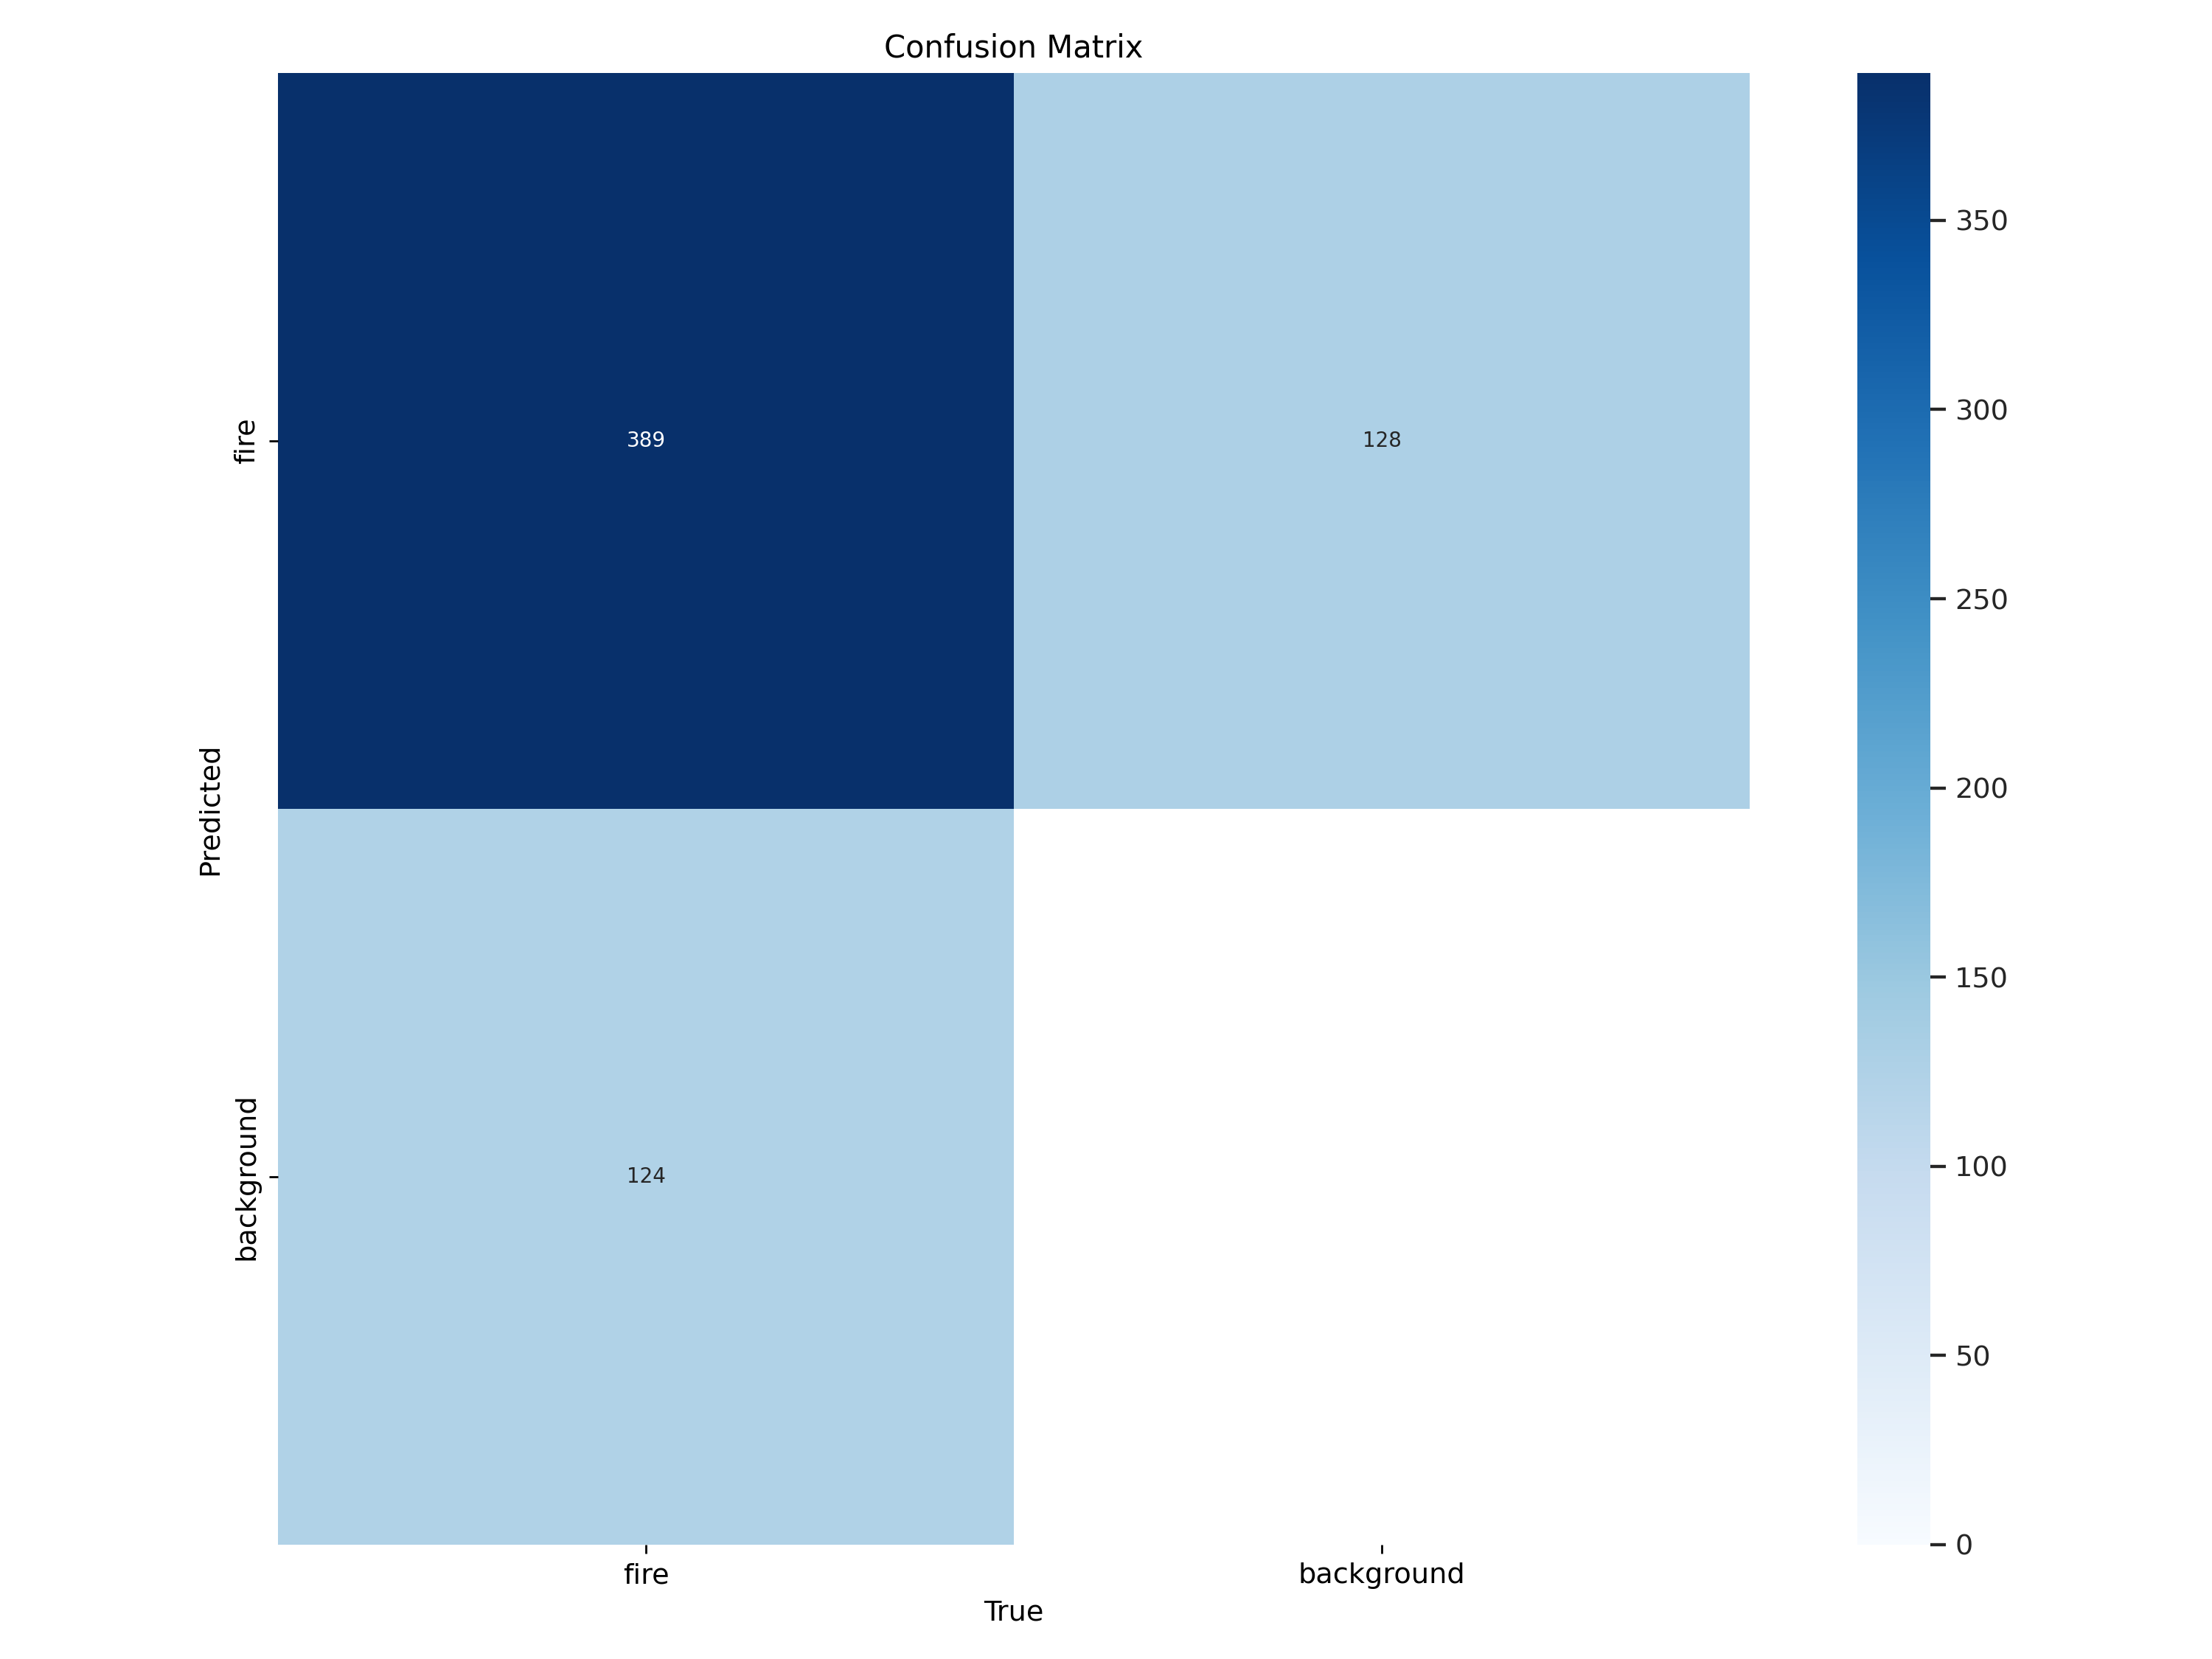

In [36]:
# Take a look at the confusion matrix of training results
from IPython.display import Image
%cd {HOME}
Image(filename=f'{HOME}/runs/detect/train4/confusion_matrix.png', width=600)

In [37]:
# Load newly trained model

import supervision as sv

model = YOLOv10(f'{HOME}/runs/detect/train4/weights/best.pt')

dataset = sv.DetectionDataset.from_yolo(
    #images_directory_path=f"{dataset.location}/valid/images",
    images_directory_path=f"{dataset.location}/valid/images",
    annotations_directory_path=f"{dataset.location}/valid/labels",
    data_yaml_path=f"{dataset.location}/data.yaml"
)

bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()


0: 640x640 1 fire, 17.1ms
Speed: 1.6ms preprocess, 17.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


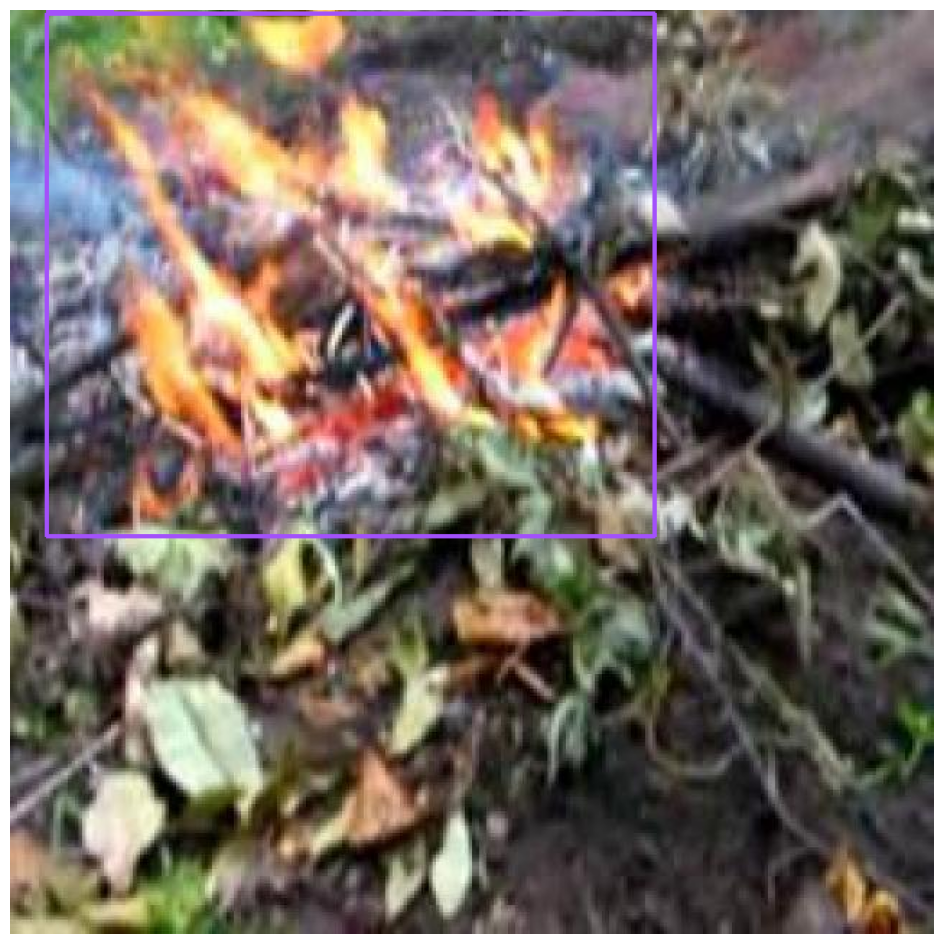

In [38]:
# Randomly select image from validation set and visualize the results

import random

random_image = random.choice(list(dataset.images.keys()))
random_image = dataset.images[random_image]

results = model(source=random_image, conf=0.25)[0]
detections = sv.Detections.from_ultralytics(results)

annotated_image = bounding_box_annotator.annotate(
    scene=random_image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image, detections=detections)

sv.plot_image(annotated_image)